In [1]:
from pathlib import Path

import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

import h5py as h5

import numba as nb
ak.numba.register_and_check()

In [2]:
proj_dir = Path.cwd().parent.parent

infile_path = proj_dir.joinpath('data/delphes/v2/hhh_test.h5')
predfile_path = proj_dir.joinpath('reports/bv2/pred_v0.h5')

plot_dir = proj_dir.joinpath('reports/bv2/figures')

In [3]:
infile = h5.File(infile_path)
predfile = h5.File(predfile_path)

In [4]:
infile['TARGETS']['h1'].keys()

<KeysViewHDF5 ['b1', 'b2', 'mask', 'pt']>

In [5]:
predfile['TARGETS']['bh1'].keys()

<KeysViewHDF5 ['assignment_probability', 'bb', 'detection_probability', 'marginal_probability']>

In [6]:
infile['TARGETS']['bh1']['bb'][0:10]

array([-1, -1,  0, -1, -1, -1, -1, -1,  0,  1])

### OptionL: examaine pt order

In [7]:
infile['TARGETS']['bh1']['pt'][0:100]

array([ 85.58358765, 146.53074646, 609.32312012,  77.26717377,
       282.46322632,  91.70096588, 218.49435425, 228.49931335,
       469.9515686 , 301.28381348,  58.23229218, 211.69009399,
       108.37065887, 108.78870392,  83.86267853, 109.72279358,
       351.31704712, 140.02876282, 166.67745972, 111.93540192,
       215.57685852,  35.19555664, 107.11416626,  67.23423004,
       239.55192566,  97.46037292, 276.11138916,  40.23224258,
       269.74707031, 318.29168701, 470.49819946,  48.68780899,
       127.03714752,  84.28048706, 140.24867249, 302.69415283,
       135.57484436, 219.75001526, 162.03977966, 104.96878815,
       276.29852295,  80.35949707,  78.07152557, 146.284729  ,
       124.21165466, 375.66247559,  26.96552467,  58.24560928,
        89.40576935, 119.52960205, 179.57537842, 224.01603699,
       142.31286621, 121.42474365, 186.70855713, 109.05266571,
        76.33929443, 111.11807251, 163.67677307,  97.18164062,
       100.74693298,  49.11566925,  64.93637848, 118.97

### Obtain python arrays for calculating purity and efficiency

In [8]:
# Collect H pt, mask, target and predicted jet and fjets for 3 Hs in each event
# h pt
h1_pt = np.array(infile['TARGETS']['h1']['pt'])
h2_pt = np.array(infile['TARGETS']['h2']['pt'])
h3_pt = np.array(infile['TARGETS']['h3']['pt'])

bh1_pt = np.array(infile['TARGETS']['bh1']['pt'])
bh2_pt = np.array(infile['TARGETS']['bh2']['pt'])
bh3_pt = np.array(infile['TARGETS']['bh3']['pt'])

# mask
h1_mask = np.array(infile['TARGETS']['h1']['mask'])
h2_mask = np.array(infile['TARGETS']['h2']['mask'])
h3_mask = np.array(infile['TARGETS']['h3']['mask'])

bh1_mask = np.array(infile['TARGETS']['bh1']['mask'])
bh2_mask = np.array(infile['TARGETS']['bh2']['mask'])
bh3_mask = np.array(infile['TARGETS']['bh3']['mask'])

# target jet/fjets
b1_h1_t = np.array(infile["TARGETS"]["h1"]['b1'])
b1_h2_t = np.array(infile["TARGETS"]["h2"]['b1'])
b1_h3_t = np.array(infile["TARGETS"]["h3"]['b1'])

b2_h1_t = np.array(infile["TARGETS"]["h1"]['b2'])
b2_h2_t = np.array(infile["TARGETS"]["h2"]['b2'])
b2_h3_t = np.array(infile["TARGETS"]["h3"]['b2'])

bb_bh1_t = np.array(infile["TARGETS"]["bh1"]['bb'])
bb_bh2_t = np.array(infile["TARGETS"]["bh2"]['bb'])
bb_bh3_t = np.array(infile["TARGETS"]["bh3"]['bb'])

# pred jet/fjets
b1_h1_p = np.array(predfile["TARGETS"]["h1"]['b1'])
b1_h2_p = np.array(predfile["TARGETS"]["h2"]['b1'])
b1_h3_p = np.array(predfile["TARGETS"]["h3"]['b1'])

b2_h1_p = np.array(predfile["TARGETS"]["h1"]['b2'])
b2_h2_p = np.array(predfile["TARGETS"]["h2"]['b2'])
b2_h3_p = np.array(predfile["TARGETS"]["h3"]['b2'])

bb_bh1_p = np.array(predfile["TARGETS"]["bh1"]['bb'])
bb_bh2_p = np.array(predfile["TARGETS"]["bh2"]['bb'])
bb_bh3_p = np.array(predfile["TARGETS"]["bh3"]['bb'])


# fatjet assignment probability
ap_bh1 = np.array(predfile["TARGETS"]["bh1"]['assignment_probability'])
ap_bh2 = np.array(predfile["TARGETS"]["bh2"]['assignment_probability'])
ap_bh3 = np.array(predfile["TARGETS"]["bh3"]['assignment_probability'])

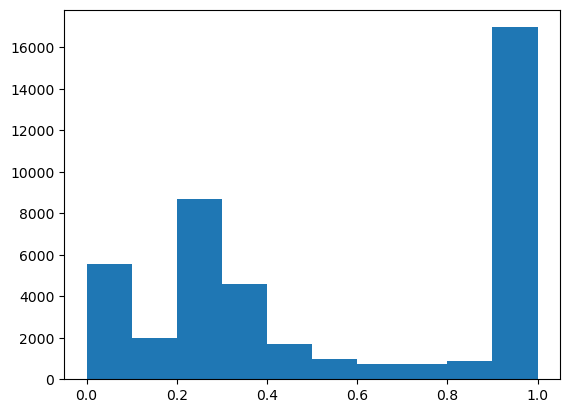

In [9]:
plt.hist(ap_bh1)
plt.show()

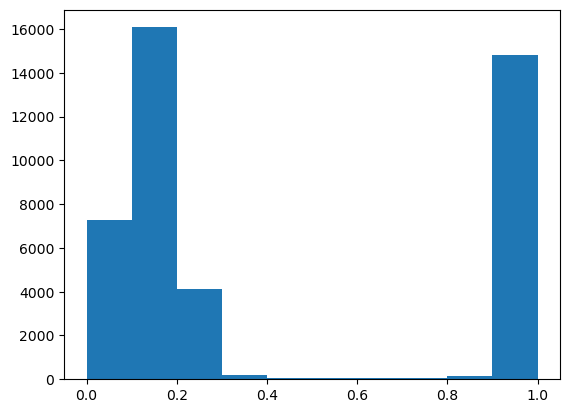

In [10]:
plt.hist(ap_bh2)
plt.show()

# Calculating efficiency (denominator should be pred)

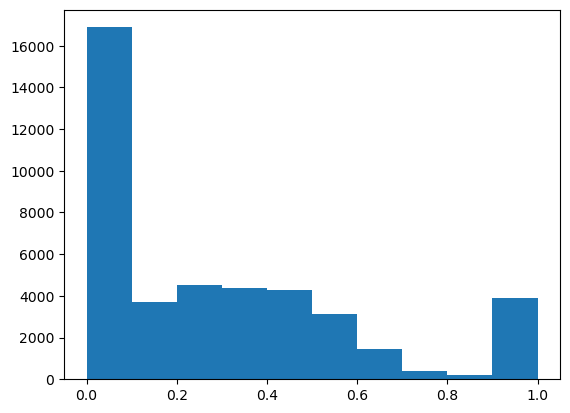

In [11]:
plt.hist(ap_bh3)
plt.show()

### As prediction h1 can be matched to target h1, 2, 3,  I will do things in the event level first

In [13]:
# convert some arrays to ak array
ap = np.concatenate((ap_bh1.reshape(-1,1), ap_bh2.reshape(-1,1), ap_bh3.reshape(-1,1)), axis=1)
ap = ak.Array(ap)
bb_bh_p = np.concatenate((bb_bh1_p.reshape(-1,1), bb_bh2_p.reshape(-1,1), bb_bh3_p.reshape(-1,1)), axis=1)
bb_bh_p = ak.Array(bb_bh_p)
bb_bh_t = np.concatenate((bb_bh1_t.reshape(-1,1), bb_bh2_t.reshape(-1,1), bb_bh3_t.reshape(-1,1)), axis=1)
bb_bh_t = ak.Array(bb_bh_t)
bh_pt = np.concatenate((bh1_pt.reshape(-1,1), bh2_pt.reshape(-1,1), bh3_pt.reshape(-1,1)), axis=1)
bh_pt = ak.Array(bh_pt)

# p: prediction
AP_threshold = 0.0
bh_filter = ap > AP_threshold
bb_bh_p_passed = bb_bh_p.mask[bh_filter]
bb_bh_p_passed = ak.drop_none(bb_bh_p_passed)

ap_passed = ap.mask[bh_filter]
ap_passed = ak.drop_none(ap_passed)

sort_by_ap = ak.argsort(ap_passed, axis=-1, ascending=False)
bb_bh_passed = bb_bh_p_passed[sort_by_ap]

In [14]:
bh_eff = []
# for each event
for bb_bh_p_event, bb_bh_t_event, bh_pt_event in zip(bb_bh_p_passed, bb_bh_t, bh_pt):
    # for each p fatjet, do we have a t fatject same with the p fatjet
    bb_bh_p_event
    for bb_p in bb_bh_p_event:
        for i, bb_t in enumerate(bb_bh_t_event):
            if bb_p == bb_t:
                bh_eff.append([bh_pt_event[i], 1])
bh_eff = np.array(bh_eff)

In [15]:
bins = np.arange(200, 1000, 100)
bin_centers = [(bins[i]+bins[i+1])/2 for i in range(bins.size-1)]
inds = np.digitize(bh_eff[:,0], bins)

np.concatenate((ap_bh1.reshape(-1,1), ap_bh2.reshape(-1,1), ap_bh3.reshape(-1,1)), axis=1)
effs_per_bin = []
for bin_i in range(1, len(bins)):
    effs_per_bin.append(bh_eff[:,1][inds==bin_i])
effs_per_bin = ak.Array(effs_per_bin)

In [16]:
for effs, bin_c in zip(effs_per_bin, bin_centers):
    print(f"{ak.sum(effs)} out of {ak.count(effs)} are matched in bin centered at {bin_c}")

6.0 out of 6 are matched in bin centered at 250.0
9.0 out of 9 are matched in bin centered at 350.0
8.0 out of 8 are matched in bin centered at 450.0
4.0 out of 4 are matched in bin centered at 550.0
1.0 out of 1 are matched in bin centered at 650.0
1.0 out of 1 are matched in bin centered at 750.0
1.0 out of 1 are matched in bin centered at 850.0


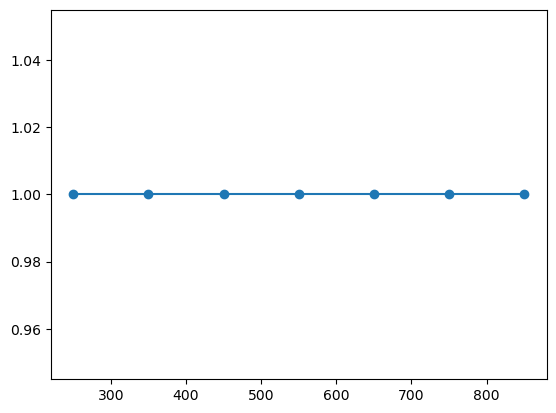

In [17]:
plt.scatter(x=bin_centers, y=ak.mean(effs_per_bin, axis=-1))
plt.errorbar(x=bin_centers, y=ak.mean(effs_per_bin, axis=-1), yerr=ak.std(effs_per_bin, axis=-1))
plt.show()

# Calculating purity 

In [ ]:
# get the truth level boosted higgs mask
bh_mask = np.concatenate((bh1_mask.reshape(-1,1), bh2_mask.reshape(-1,1), bh3_mask.reshape(-1,1)), axis=1)
bh_mask = ak.Array(bh_mask)

# applying masks to the target bh's bb indices:
bb_bh_t_selected = bb_bh_t.mask[bh_mask]
bb_bh_t_selected = ak.drop_none(bb_bh_t_selected)

